In [54]:
import os
import gym
import random
from matplotlib import pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from kaggle_environments import make
from tqdm import tqdm

In [75]:
class ConnectX(gym.Env):
    def __init__(self, switch_prob=0.5):
        self.env = make('connectx', debug=False)
        self.pair = [None, 'random']
        self.model_train = self.env.train(self.pair)
        
        self.action_space = gym.spaces.Discrete(self.env.configuration.columns)
        self.observation_space = gym.spaces.Discrete(self.env.configuration.columns * self.env.configuration.rows)

    def step(self, action):
        return self.model_train.step(action)
    
    def reset(self):
        return self.model_train.reset()

In [76]:
class Network(nn.Module):
    def __init__(self, input_state: int, output_action: int, hidden_layer: list):
        super(Network, self).__init__()
        self.fc = nn.ModuleList([])
        self.fc = self.fc.append(nn.Linear(input_state + 1, hidden_layer[0]))
        for i in range(1, len(hidden_layer)):
            self.fc.append(nn.Linear(hidden_layer[i - 1], hidden_layer[i]))
        self.output_layer = nn.Linear(hidden_layer[-1], output_action)

    def forward(self, x):
        for layer in self.fc:
            x = torch.tanh(layer(x))
        x = self.output_layer(x)
        return x

    def sample_action(self, obs, epsilon_greedy):
        out = self.forward(obs)
        prob = random.random()
        if prob < epsilon_greedy:
            return random.randint(0, 1)
        else:
            return out.argmax().item()


class DQN:
    def __init__(self, state_n, action_n, hidden_layer, gamma, max_buffer, min_buffer, batch_size, lr):
        self.action_n = action_n
        self.batch_size = batch_size
        self.gamma = gamma
        self.model = Network(input_state=state_n, hidden_layer=hidden_layer, output_action=action_n)
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.criterion = nn.MSELoss()
        self.replay_buffer = {'s': [], 'a': [], 'r': [], 's_next': [], 'done': []}  # The buffer
        self.max_buffer = max_buffer
        self.min_buffer = min_buffer

    def predict(self, inputs):
        return self.model(torch.from_numpy(inputs).float())

    def train(self, train_net):
        if len(self.replay_buffer['s']) < self.min_buffer:
            # Only start the training process when we have enough experiences in the buffer
            return 0

        # Randomly select n experience in the buffer, n is batch-size
        random_sample = np.random.randint(low=0, high=len(self.replay_buffer['s']), size=self.batch_size)
        states = np.asarray([self.preprocess(self.replay_buffer['s'][i]) for i in random_sample])
        actions = np.asarray([self.replay_buffer['a'][i] for i in random_sample])
        rewards = np.asarray([self.replay_buffer['r'][i] for i in random_sample])

        states_next = np.asarray([self.preprocess(self.replay_buffer['s_next'][i]) for i in random_sample])
        dones = np.asarray([self.replay_buffer['done'][i] for i in random_sample])
        value_next = np.max(train_net.predict(states_next).detach().numpy(), axis=1)
        actual_values = np.where(dones, rewards, rewards + self.gamma * value_next)

        actions = np.expand_dims(actions, axis=1)
        actions_one_hot = torch.FloatTensor(self.batch_size, self.action_n).zero_()
        actions_one_hot = actions_one_hot.scatter_(1, torch.LongTensor(actions), 1)
        selected_action_values = torch.sum(self.predict(states) * actions_one_hot, dim=1)
        actual_values = torch.FloatTensor(actual_values)

        self.optimizer.zero_grad()
        loss = self.criterion(selected_action_values, actual_values)
        loss.backward()
        self.optimizer.step()

    # Using Epsilon greedy to
    def get_action(self, state:int, epsilon_greedy:float):
        if np.random.random() < epsilon_greedy:
            return int(np.random.choice([c for c in range(self.action_n) if state["board"][c] == 0]))
        else:
            prediction = self.predict(np.atleast_2d(self.preprocess(state)))[0].detach().numpy()
            for i in range(self.action_n):
                if state["board"][i] != 0:
                    prediction[i] = -1e7
            return int(np.argmax(prediction))

    # Replay_Buffer Controller
    def add_buffer(self, buffer:dict):
        if len(self.replay_buffer['s']) >= self.max_buffer:
            for key in self.replay_buffer.keys():
                self.replay_buffer[key].pop(0)
        for key, value in buffer.items():
            self.replay_buffer[key].append(value)

    # Use these methods if you want to save/load weights
    def copy_weights(self, TNet):
        self.model.load_state_dict(TNet.state_dict())

    def save_weights(self, path):
        torch.save(self.model.state_dict(), path)

    def load_weights(self, path):
        self.model.load_state_dict(torch.load(path))

    # All of the states are recorded as board and those are also should be recorded in the mark
    def preprocess(self, state):
        result = state["board"][:]
        result.append(state.mark)
        return result

In [77]:
class Play:

    def __init__(self, env, TrainNet, TargetNet, epsilon_greedy, copy_step):
        self.env = env
        self.TrainNet = TrainNet
        self.TargetNet = TargetNet
        self.epsilon_greedy = epsilon_greedy
        self.copy_step = copy_step

    def play_game(self):
        rewards = 0
        cnt = 0
        done = False
        obs = self.env.reset()
        # obs = self.state

        while not done:
            action = self.TrainNet.get_action(obs, self.epsilon_greedy)
            prev_obs = obs
            obs, reward, done, _ = self.env.step(action)

            # Reward Rules
            if done:
                if reward == 1:
                    reward = 1
                elif reward == 0:
                    reward = -1
                else:
                    reward = 0
            else:
                reward = 0

            rewards += reward

            buffer = {'s': prev_obs, 'a': action, 'r': reward, 's_next': obs, 'done': done}
            self.TrainNet.add_buffer(buffer)
            self.TrainNet.train(self.TargetNet)
            cnt += 1
            if cnt % self.copy_step == 0:
                self.TargetNet.copy_weights(self.TrainNet)
        return rewards

In [80]:
import sys
import os
from tqdm import tqdm
from kaggle_environments import make
import numpy as np

# from src import dqn
# from src import environment
# from src import play


env = ConnectX()

model_params = {
    "state_n": env.observation_space.n,
    "action_n": env.action_space.n,
    "hidden_layer": [128, 128, 128, 128, 128],
    "gamma": 0.99,
    "max_buffer": 1000,
    "min_buffer": 100,
    "batch_size": 50,
    "lr": 0.01,
}

params = {
    "episodes": 300,
    "epsilon_greedy": 0.5,
    "copy_step": 50
}


if __name__ == "__main__":

    # Model Training
    TrainNet = DQN(**model_params)
    TargetNet = DQN(**model_params)

    # Stepping Episodes
    all_episode_sum_reward = np.empty(params["episodes"])
    all_episode_avg_reward = np.empty(params["episodes"])
    # play_game(env, TrainNet, TargetNet, params["epsilon_greedy"], params["copy_step"])

    _play = Play(env, TrainNet, TargetNet, params["epsilon_greedy"], params["copy_step"])

    progress = tqdm(range(params["episodes"]))

    for steps in progress:
        # one_episode_sum_reward = play_game(env, TrainNet, TargetNet, params["epsilon_greedy"], params["copy_step"])
        one_episode_sum_reward = _play.play_game()
        all_episode_sum_reward[steps] = one_episode_sum_reward
        one_episode_avg_reward = np.mean(all_episode_sum_reward[max(0, steps - 100):(steps+1)])
        all_episode_avg_reward[steps] = one_episode_avg_reward

        progress.set_postfix({
            "episode_reward": one_episode_sum_reward,
            "average reward": one_episode_avg_reward
        })

100%|█| 300/300 [00:25<00:00, 11.83it/s,


In [88]:
def agent(observation, configuration):

    state = observation.board[:]
    state.append(observation.mark)
    
    out = TrainNet.predict(np.atleast_2d(TrainNet.preprocess(observation)))[0].detach().numpy()

    for i in range(configuration.columns):
        if observation.board[i] != 0:
            out[i] = -1e7

    return int(np.argmax(out))

In [89]:
env_run = make("connectx", debug=True)
env_run.reset()
env_run.run([agent, "random"])
env_run.render(mode="ipython", width=500, height=450)

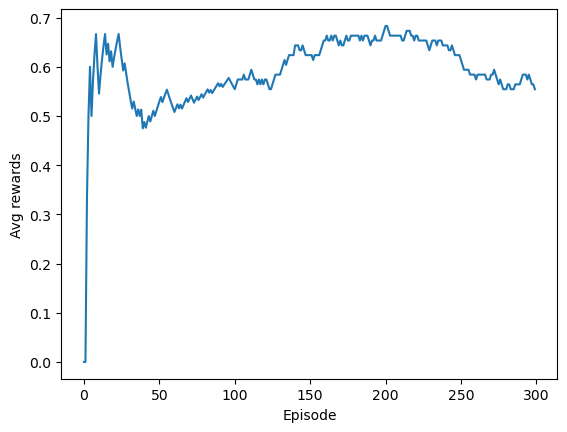

In [83]:
plt.plot(all_avg_rewards)
plt.xlabel('Episode')
plt.ylabel('Avg rewards')
plt.show()